# Movie knowledge graph

In [1]:

from relationalai.early_access.builder import Model, where, select, define, data, String
import pandas as pd

## Read in data from CSVs and define nodeects

In [2]:
model = Model("movies2", dry_run=False)
Concept, Relationship = model.Concept, model.Relationship

Movie = Concept("Movie")
Person = Concept("Person")
Directed = Concept("Directed")
ActedIn = Concept("ActedIn")

data(pd.read_csv("movies_data/movies.csv")).into(Movie, keys=["id"])
data(pd.read_csv("movies_data/person.csv")).into(Person, keys=["id"])
data(pd.read_csv("movies_data/directed.csv")).into(Directed, keys=["id"])
data(pd.read_csv("movies_data/actedin.csv")).into(ActedIn, keys=["id"])

In [3]:
Node = Concept("Node")

define(Node.new(id = Movie.id))
define(Node.new(id = Person.id))

Node.kind = Relationship("{Node} has type {String})")
Node.label = Relationship("{Node} has label {String})")

define(Node.kind("movie")).where(Node.id == Movie.id)
define(Node.kind("person")).where(Node.id == Person.id)

define(Node.label(Movie.title)).where(Node.id == Movie.id)
define(Node.label(Person.name)).where(Node.id == Person.id)


In [4]:
type_df = select(Node.label, Node.kind).to_df()
type_df

string string2
0           A Few Good Men   movie
1    A League of Their Own   movie
2             Aaron Sorkin  person
3                Al Pacino  person
4        Annabella Sciorra  person
..                     ...     ...
160   What Dreams May Come   movie
161   When Harry Met Sally   movie
162            Wil Wheaton  person
163        You've Got Mail   movie
164           Zach Grenier  person

[165 rows x 2 columns]

In [5]:
type_map = dict(zip(type_df.iloc[:, 0], type_df.iloc[:, 1]))
type_map

{'A Few Good Men': 'movie',
 'A League of Their Own': 'movie',
 'Aaron Sorkin': 'person',
 'Al Pacino': 'person',
 'Annabella Sciorra': 'person',
 'Anthony Edwards': 'person',
 'Apollo 13': 'movie',
 'As Good as It Gets': 'movie',
 'Audrey Tautou': 'person',
 'Ben Miles': 'person',
 'Bicentennial Man': 'movie',
 'Bill Paxton': 'person',
 'Bill Pullman': 'person',
 'Billy Crystal': 'person',
 'Bonnie Hunt': 'person',
 'Brooke Langton': 'person',
 'Bruno Kirby': 'person',
 'Cameron Crowe': 'person',
 'Carrie Fisher': 'person',
 'Carrie-Anne Moss': 'person',
 'Cast Away': 'movie',
 "Charlie Wilson's War": 'movie',
 'Charlize Theron': 'person',
 'Chris Columbus': 'person',
 'Christian Bale': 'person',
 'Christina Ricci': 'person',
 'Christopher Guest': 'person',
 'Clint Eastwood': 'person',
 'Cloud Atlas': 'movie',
 'Corey Feldman': 'person',
 'Cuba Gooding Jr.': 'person',
 'Danny DeVito': 'person',
 'Dave Chappelle': 'person',
 'David Mitchell': 'person',
 'David Morse': 'person',
 'Demi 

## Define edges

In [6]:
movie, person = Node.ref(), Node.ref()

edge = Relationship("Edge from {from:Node} to {to:Node} with type {label:String}")

define(edge(movie, person, "directed")).where(
    Directed.from_ == person.id,
    Directed.to == movie.id
)

define(edge(person, movie, "acted")).where(
    ActedIn.from_ == person.id,
    ActedIn.to == movie.id
)

In [7]:
node, node2 = Node.ref(), Node.ref()
edge_label = String.ref()

df = select(node.label, edge_label, node2.label).where(edge(node, node2, edge_label)).to_df()

df

string   string2               string3
0           A Few Good Men  directed            Rob Reiner
1    A League of Their Own  directed        Penny Marshall
2             Aaron Sorkin     acted        A Few Good Men
3                Al Pacino     acted  The Devil's Advocate
4        Annabella Sciorra     acted  What Dreams May Come
..                     ...       ...                   ...
206   When Harry Met Sally  directed            Rob Reiner
207            Wil Wheaton     acted           Stand By Me
208        You've Got Mail  directed           Nora Ephron
209           Zach Grenier     acted            RescueDawn
210           Zach Grenier     acted               Twister

[211 rows x 3 columns]

## Visualize the knowledge graph

In [8]:
import graphviz
from graphviz import Digraph


In [19]:
def make_graph(df):
    g = graphviz.Graph(engine='neato')
    g.graph_attr['overlap'] = 'prism' # 'false'
    g.attr(size='10,6') # Set the size of the graph (inches)

    for row in df.itertuples(name=None, index=False):
        g.node(row[0], label=row[0], style='filled', fillcolor='lightblue' if type_map.get(row[0]) == 'movie' else 'lightgreen')
        g.node(row[2], label=row[2], style='filled', fillcolor='lightblue' if type_map.get(row[2]) == 'movie' else 'lightgreen')
        g.edge(row[0], row[2], style='solid', color='red' if row[1] == 'acted' else 'blue')

    node = Node.ref()


    return g

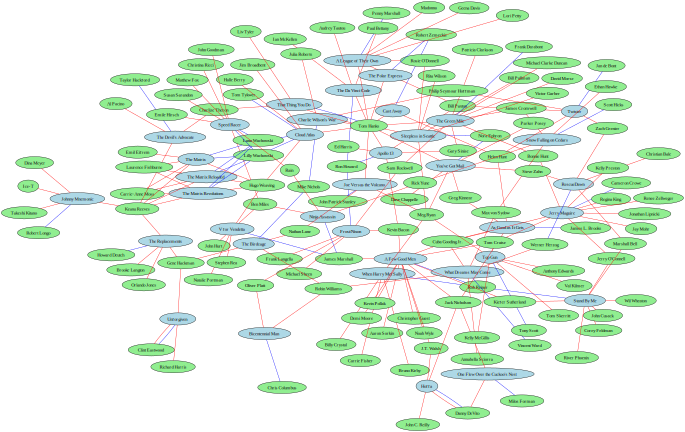

In [20]:
make_graph(df)

In [21]:
# Make edge undirected since we can't treat backwards edges:

obj, obj2 = Node.ref(), Node.ref()
label = String.ref()

define(edge(obj, obj2, label)).where(
    edge(obj2, obj, label))

In [22]:
df = select(node.label, node2.label).where(edge(node, node2, "acted")).to_df()

df

string            string2
0     A Few Good Men       Aaron Sorkin
1     A Few Good Men  Christopher Guest
2     A Few Good Men   Cuba Gooding Jr.
3     A Few Good Men         Demi Moore
4     A Few Good Men         J.T. Walsh
..               ...                ...
331  You've Got Mail       Parker Posey
332  You've Got Mail         Steve Zahn
333  You've Got Mail          Tom Hanks
334     Zach Grenier         RescueDawn
335     Zach Grenier            Twister

[336 rows x 2 columns]

## Find paths

In [23]:
from relationalai.early_access.builder import Model, Integer, select, String, where, define
from relationalai.early_access.builder.std import strings

from relationalai.early_access.paths.graph import Graph
from relationalai.early_access.paths.api import (
    path, star, match, plus, node_filter
)

graph = Graph(model, Node, edge)

In [24]:
def parse_paths_from_dataframe(df):
    """
    Parses a DataFrame representing graph paths into a list of paths.
    Each path is returned as a flat list alternating: node, label, node, label, ...

    The DataFrame must have the following columns:
      - path_idx: identifier for the path
      - step_idx: order within the path
      - label: label on the edge (empty for first step)
      - node: node ID

    :param df: pd.DataFrame with columns [path_idx, step_idx, label, node]
    :return: List[List], list of paths
    """
    paths = []

    if df.empty:
        return paths

    for path_id, group in df.groupby(df.columns[0]):  # Group by path index
        group = group.sort_values(df.columns[1])      # Sort by step index
        path = [group.iloc[0][df.columns[3]]]         # Start with the first node
        for _, row in group.iloc[1:].iterrows():
            path.append(row[df.columns[2]])           # Add label
            path.append(row[df.columns[3]])           # Add node
        paths.append(path)

    return paths

def get_paths_df(paths):
    i, k = Integer.ref(), Integer.ref()
    node = graph.Node.ref()
    label = String.ref()

    df = select(i, k, label, node.label).where(
        paths(i, k, label, node)
    ).to_df()

    return df

def show_paths_df(df):

    df = pd.DataFrame(parse_paths_from_dataframe(df))

    df = df.fillna(value="")

    return df

def make_paths_graph(df):
    tuples = []
    paths = parse_paths_from_dataframe(df)

    for path in paths:
        for i in range(0, len(path) - 2, 2):
            tuples.append((path[i], path[i + 1], path[i + 2]))

    return make_graph(pd.DataFrame(tuples))



In [25]:
def make_source_and_target_sets(sources, targets):
# # create source and target sets:
    Source = model.Relationship("{Node} is a source node")
    Target = model.Relationship("{Node} is a target node")

    node = Node.ref()

    for src in sources:
        define(Source(node)).where(node.label == src)

    for tgt in targets:
        define(Target(node)).where(node.label == tgt)

    return Source, Target


In [26]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) # To prevent truncation of long text within cells

## Examples

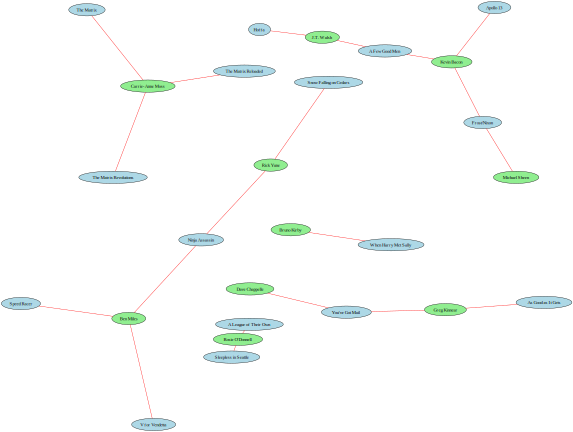

In [48]:
pattern = path("acted") # , "acted", "acted")"]

paths = match(graph, pattern, num_paths = 20)

raw_df = paths.to_df()

df = get_paths_df(paths)

make_paths_graph(df)


In [49]:
raw_df

int  int2 string                    node
0     1     0         xjO9B23qYNN8yCC6eKGXnw
1     1     1  acted  ad3qwuTxvjHd1yWAW3s6GQ
2     2     0         V8XhydU6q0uc+6yBAlcdrA
3     2     1  acted  1Gfb45vVqftvegcGQNBL9g
4     3     0         V8XhydU6q0uc+6yBAlcdrA
5     3     1  acted  cKbiXWiSD3GEhxZpNgUtHQ
6     4     0         V8XhydU6q0uc+6yBAlcdrA
7     4     1  acted  5Ke0jzsAZasjYokKLzzNiw
8     5     0         c+B1CmVh/2wQLJYUgAHpCw
9     5     1  acted  S5/Hz0sZMVvrmBmGzp5UHw
10    6     0         c+B1CmVh/2wQLJYUgAHpCw
11    6     1  acted  NMvV0JbJ8+SKebhI8V0SEw
12    7     0         c+B1CmVh/2wQLJYUgAHpCw
13    7     1  acted  ad3qwuTxvjHd1yWAW3s6GQ
14    8     0         GQgdz6IKCSuXo1PGhlzt6A
15    8     1  acted  fxbDFg2pzraKF/SdHoL0nw
16    9     0         GQgdz6IKCSuXo1PGhlzt6A
17    9     1  acted  JjQ8wkabFirU7QaDS2Q8+Q
18   10     0         sjLXlfoiebK8sxVGL3Mt5w
19   10     1  acted  3JoanEQCQvpDcnJUGwUCjA
20   11     0         sjLXlfoiebK8sxVGL3Mt5w
21   11     1  acted  ZPc+WT7cLIEGTuzTAOxlcA
22   12     0         sjLXlfoiebK8sxVGL3Mt5w
23   12     1  acted  li6E0nxOb0fGCNW1OTMBDQ
24   13     0         TNOqtlrnS3Xqy3tXPKk+Jg
25   13     1  acted  iCTF/6aHSsAEL1cDWEHV9w
26   14     0         TNOqtlrnS3Xqy3tXPKk+Jg
27   14     1  acted  s2bERaxib3vCCR7+IU6OOA
28   15     0         K52wSgD35oWlSnPK6Gxwlw
29   15     1  acted  /jffxF0EBZyZhkpeHDiX6A
30   16     0         K52wSgD35oWlSnPK6Gxwlw
31   16     1  acted  cKbiXWiSD3GEhxZpNgUtHQ
32   17     0         SN3GzU1hpRS/MfcZXyPt3A
33   17     1  acted  N7KgYy5bqxdh3VPonRRWpA
34   18     0         EYXvC5wUEYEQU6D8eDVcZg
35   18     1  acted  s2bERaxib3vCCR7+IU6OOA
36   19     0         DyNJUNd+SoX5mxnSI3gDMw
37   19     1  acted  S5/Hz0sZMVvrmBmGzp5UHw
38   20     0         DyNJUNd+SoX5mxnSI3gDMw
39   20     1  acted  oW9Q7JDm07FN4qzLouv35g

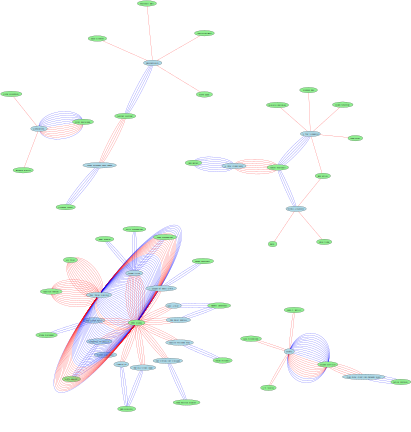

In [50]:

pattern = path("directed", "acted", "directed", "acted")

paths = match(graph, pattern)

df = get_paths_df(paths)

make_paths_graph(df)

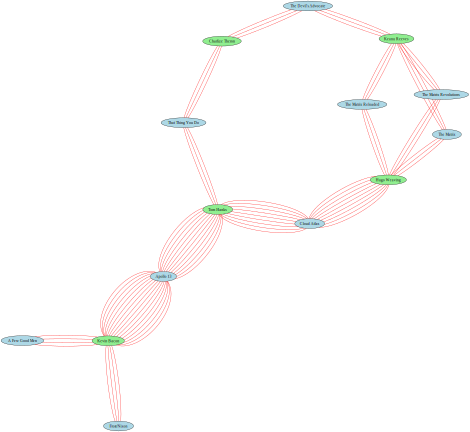

In [ ]:
pattern = path(
        node_filter(lambda n: n.label == "Keanu Reeves"),
        star("acted"),
        node_filter(lambda n: n.label == "Kevin Bacon"),
        "acted"
    )

paths = match(graph, pattern)

df = get_paths_df(paths)

make_paths_graph(df)

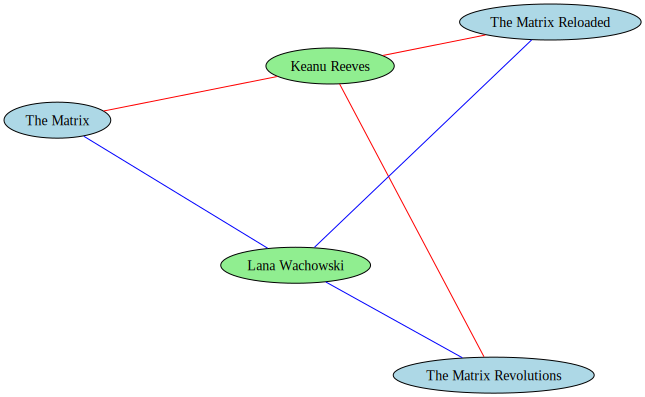

In [ ]:
pattern = path("acted", "directed")

sources = ["Keanu Reeves"]
targets = ["Lana Wachowski"]

Source, Target = make_source_and_target_sets(sources, targets)

paths = match(graph, pattern, Source, Target)

df = get_paths_df(paths)

make_paths_graph(df)

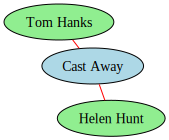

In [33]:
pattern = path("acted", "acted") # , "acted", "acted")

sources = ["Tom Hanks"]
targets = ["Helen Hunt"]

Source, Target = make_source_and_target_sets(sources, targets)

paths = match(graph, pattern, Source, Target)

# paths.inspect()
# show_paths(paths)



# paths = match(graph, pattern) # , Source, Target)

df = get_paths_df(paths)

make_paths_graph(df)


In [34]:

# pattern = path("acted", node_filter(lambda node: node.kind=="Movie"), "acted")

# paths = match(graph, pattern) # , Source, Target)

# show_paths(paths)

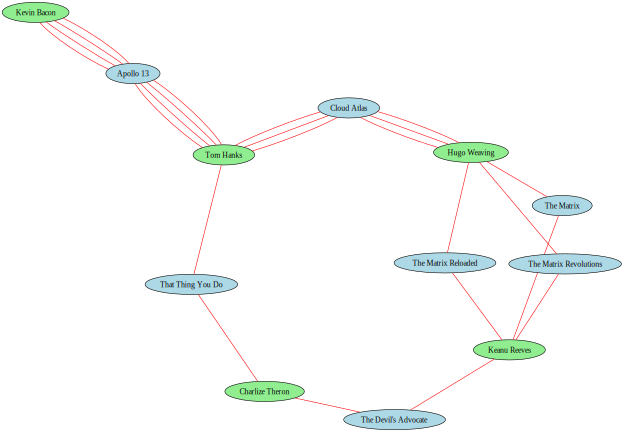

In [35]:
pattern = star("acted")    # , "acted")

sources = ["Keanu Reeves"]
targets = ["Kevin Bacon"]

Source, Target = make_source_and_target_sets(sources, targets)

paths = match(graph, pattern, Source, Target)


# paths = match(graph, pattern) # , Source, Target)

df = get_paths_df(paths)

make_paths_graph(df)


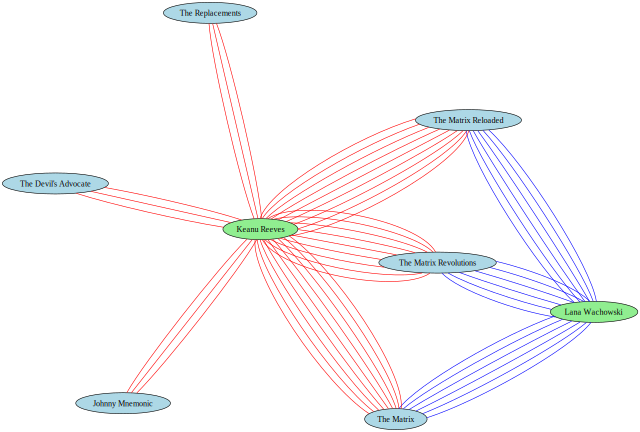

In [36]:
pattern = path(
        node_filter(lambda node: node.label == "Lana Wachowski"),
        "directed",
        "acted",
        node_filter(lambda node: node.label == "Keanu Reeves"),
        "acted"
    )

paths = match(graph, pattern)


# paths = match(graph, pattern) # , Source, Target)

df = get_paths_df(paths)

make_paths_graph(df)


In [37]:
import networkx as nx

ng = nx.DiGraph()

In [38]:
graph.Edge

In [39]:
ng.add_node("a", label="A", color="blue")
ng.add_edge("a", "b", label="c", color="red")

In [40]:
ng.edges

OutEdgeView([('a', 'b')])

In [41]:
import gravis

In [42]:
gravis.d3(ng)

In [43]:
df

int  int2    string                 string2
0     1     0                    Lana Wachowski
1     1     1  directed  The Matrix Revolutions
2     1     2     acted            Keanu Reeves
3     1     3     acted  The Matrix Revolutions
4     2     0                    Lana Wachowski
5     2     1  directed  The Matrix Revolutions
6     2     2     acted            Keanu Reeves
7     2     3     acted        The Replacements
8     3     0                    Lana Wachowski
9     3     1  directed  The Matrix Revolutions
10    3     2     acted            Keanu Reeves
11    3     3     acted     The Matrix Reloaded
12    4     0                    Lana Wachowski
13    4     1  directed  The Matrix Revolutions
14    4     2     acted            Keanu Reeves
15    4     3     acted    The Devil's Advocate
16    5     0                    Lana Wachowski
17    5     1  directed  The Matrix Revolutions
18    5     2     acted            Keanu Reeves
19    5     3     acted         Johnny Mnemonic
20    6     0                    Lana Wachowski
21    6     1  directed  The Matrix Revolutions
22    6     2     acted            Keanu Reeves
23    6     3     acted              The Matrix
24    7     0                    Lana Wachowski
25    7     1  directed     The Matrix Reloaded
26    7     2     acted            Keanu Reeves
27    7     3     acted  The Matrix Revolutions
28    8     0                    Lana Wachowski
29    8     1  directed     The Matrix Reloaded
30    8     2     acted            Keanu Reeves
31    8     3     acted        The Replacements
32    9     0                    Lana Wachowski
33    9     1  directed     The Matrix Reloaded
34    9     2     acted            Keanu Reeves
35    9     3     acted     The Matrix Reloaded
36   10     0                    Lana Wachowski
37   10     1  directed     The Matrix Reloaded
38   10     2     acted            Keanu Reeves
39   10     3     acted    The Devil's Advocate
40   11     0                    Lana Wachowski
41   11     1  directed     The Matrix Reloaded
42   11     2     acted            Keanu Reeves
43   11     3     acted         Johnny Mnemonic
44   12     0                    Lana Wachowski
45   12     1  directed     The Matrix Reloaded
46   12     2     acted            Keanu Reeves
47   12     3     acted              The Matrix
48   13     0                    Lana Wachowski
49   13     1  directed              The Matrix
50   13     2     acted            Keanu Reeves
51   13     3     acted  The Matrix Revolutions
52   14     0                    Lana Wachowski
53   14     1  directed              The Matrix
54   14     2     acted            Keanu Reeves
55   14     3     acted        The Replacements
56   15     0                    Lana Wachowski
57   15     1  directed              The Matrix
58   15     2     acted            Keanu Reeves
59   15     3     acted     The Matrix Reloaded
60   16     0                    Lana Wachowski
61   16     1  directed              The Matrix
62   16     2     acted            Keanu Reeves
63   16     3     acted    The Devil's Advocate
64   17     0                    Lana Wachowski
65   17     1  directed              The Matrix
66   17     2     acted            Keanu Reeves
67   17     3     acted         Johnny Mnemonic
68   18     0                    Lana Wachowski
69   18     1  directed              The Matrix
70   18     2     acted            Keanu Reeves
71   18     3     acted              The Matrix

In [44]:



def make_networkx_graph(df):
    g = nx.DiGraph(engine='neato')
    # g.graph_attr['overlap'] = 'prism' # 'false'
    # g.attr(size='12,8') # Set the size of the graph (inches)

    

    for row in df.itertuples(name=None, index=False):
        g.add_edge(row[0], row[2], label=row[1])

    return g

def make_networkx_paths_graph(df):
    tuples = []
    paths = parse_paths_from_dataframe(df)

    for path in paths:
        for i in range(0, len(path) - 2, 2):
            tuples.append((path[i], path[i + 1], path[i + 2]))

    return make_networkx_graph(pd.DataFrame(tuples))


In [45]:
gravis.d3(make_networkx_paths_graph(df), edge_curvature=0.3)

In [46]:
nx.D

AttributeError: module 'networkx' has no attribute 'D'